# Analysis of scRNA-seq data from activated PBMCs in TWINS only

In CVID and healthy control, 10X platform

09.02.2021: reanalysis, correcting the bug in bertie function

This is a preprocessing notebook, so this happens here:

Step-by-step workflow - **different to the scRNA-seq integration in doublet calling**:

- load
- filter genes, cells, add info
- perform **step 1** of calling doublets using Krzysztof's bertie doublet caller:
    - see bertie_doublet_caller.ipynb in /home/jovyan/ and read comments
- concatenate
- add doublet scores from saved tables (bertie)
- filter MT-high cells
- make cells (obs) and var (genes) unique
- parsing souporcell deconvolution results
- save preprocessed object

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import scrublet as scr
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import bbknn
#import scrublet as scr # requires 'pip install scrublet'
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [15]:
np.random.seed(0)

In [16]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [42]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

A Benjamini-Hochberg function for later. Running FDR is surprisingly inconvenient using built-in Python options.

In [18]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.
    
    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

In [19]:
###################
# doublet calling #
###################

def bertie(adata_sample, sample):
    
    scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']
    
    adata_sample_copy = adata_sample.copy()
    # set up and run Scrublet
    scrub = scr.Scrublet(adata_sample_copy.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata_sample_copy.obs['scrublet_score'] = doublet_scores
    
    # overcluster prep. run turbo basic scanpy pipeline
    sc.pp.normalize_per_cell(adata_sample_copy, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sample_copy)
    sc.pp.highly_variable_genes(adata_sample_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sample_copy = adata_sample_copy[:, adata_sample_copy.var['highly_variable']]
    adata_sample_copy = adata_sample_copy.copy()
    sc.pp.scale(adata_sample_copy, max_value=10)
    sc.tl.pca(adata_sample_copy, svd_solver='arpack')
    sc.pp.neighbors(adata_sample_copy)
    
    # overclustering proper - do basic clustering first, then cluster each cluster
    sc.tl.louvain(adata_sample_copy)
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        sc.tl.louvain(adata_sample_copy, restrict_to=('louvain',[clus]))
        adata_sample_copy.obs['louvain'] = adata_sample_copy.obs['louvain_R']
        
    # compute the cluster scores - the median of Scrublet scores per overclustered cluster
    for clus in np.unique(adata_sample_copy.obs['louvain']):
        adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_cluster_score'] = \
            np.median(adata_sample_copy.obs.loc[adata_sample_copy.obs['louvain']==clus, 'scrublet_score'])
        
    # now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
    med = np.median(adata_sample_copy.obs['scrublet_cluster_score'])
    mask = adata_sample_copy.obs['scrublet_cluster_score']>med
    mad = np.median(adata_sample_copy.obs['scrublet_cluster_score'][mask]-med)
    
    #let's do a one-sided test. the Bertie write-up does not address this but it makes sense
    pvals = 1-scipy.stats.norm.cdf(adata_sample_copy.obs['scrublet_cluster_score'], loc=med, scale=1.4826*mad)
    adata_sample_copy.obs['bh_pval'] = bh(pvals)
    
    # getting calculated values to the initial object with raw count values
    for col in scorenames:
        adata_sample.obs[col] = adata_sample_copy.obs[col]
    
    return adata_sample.obs[scorenames]

## Reading and preprocessing

In [20]:
samples_activation = ['Immunodeficiency8103070', # seq_batch 1
                      'Immunodeficiency8103072', 'Immunodeficiency8103073', # seq_batch 2
                      'Immunodeficiency8103074', # seq_batch 3
                      'Immunodeficiency8103076', 'Immunodeficiency8103077'] # seq_batch 4

In [21]:
# Annotation / metadata
sample_to_condition_activation = {}

# First 3 is CVID
# Last 3 is healthy (CONTROL)

sample_to_condition_activation['Immunodeficiency8103070'] = ['CVID', 'CTRL']
sample_to_condition_activation['Immunodeficiency8103072'] = ['CVID', 'CD40L']
sample_to_condition_activation['Immunodeficiency8103073'] = ['CVID', 'CD3']

sample_to_condition_activation['Immunodeficiency8103074'] = ['CONTROL', 'CTRL']
sample_to_condition_activation['Immunodeficiency8103076'] = ['CONTROL', 'CD40L']
sample_to_condition_activation['Immunodeficiency8103077'] = ['CONTROL', 'CD3']


In the next cell below:
- read the raw file (output of cellranger)
- do step 1 of calling doublets according to bertie doublet caller and adding all the scores 
- Add %mt genes
- Add relevant annotation info

Later after looking at QC:
- Filter: a) cells (< 200 genes); b) genes (< 3 cells);

In [37]:
%%time

holder = []

scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval']

samples_activation = list(samples_activation)

for sample in samples_activation:
    print('sample',sample, list(samples_activation).index(sample)+1,'out of',len(samples_activation))
    path = '/home/jovyan/notebooks/Vento_Lab/CVID/activation_matrices/filtered_feature_bc_matrix_'+sample+'.h5'
    holder.append(sc.read_10x_h5(path))
    
    holder[-1].obs['barcode_sample'] = [i + '_' + sample for i in list(holder[-1].obs.index)]
    
    holder[-1].var_names_make_unique()
    holder[-1].obs_names_make_unique()
 
    # Filer cells with less than 200 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=200)
    
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    
    # Adding metadata - condition & activation molecule
    holder[-1].obs['condition'] = sample_to_condition_activation[sample][0]
    holder[-1].obs['activation'] = sample_to_condition_activation[sample][1]
    holder[-1].obs['technique'] = '10X'
    
    # Sample information
    holder[-1].obs['sample'] = sample
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    
    
    # calling doublets on current sample's adata which is holder[-1]
    print('going on to call doublets (write doublet scores into tables) with bertie')
    scores_table = bertie(holder[-1], sample)
    if list(scores_table.index) == list(holder[-1].obs.index):
        print('indices in current bertie table and sample adata are matching, assigning scores')
        for meta in scorenames:
            holder[-1].obs[meta] = scores_table[meta]
    else:
        print('indices in current bertie table and sample adata are NOT matching')
    


sample Immunodeficiency8103070 1 out of 6
reading /home/jovyan/notebooks/Vento_Lab/CVID/activation_matrices/filtered_feature_bc_matrix_Immunodeficiency8103070.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 9 cells that haveless than 200 genes expressed
filtered out 18565 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clu

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 54 cells that haveless than 200 genes expressed
filtered out 18114 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clu

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 57 cells that haveless than 200 genes expressed
filtered out 18119 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clu

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 6 cells that haveless than 200 genes expressed
filtered out 20391 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clus

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 70 cells that haveless than 200 genes expressed
filtered out 18728 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clu

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 101 cells that haveless than 200 genes expressed
filtered out 16983 genes that are detectedin less than 3 cells
going on to call doublets (write doublet scores into tables) with bertie
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 c

# QC, cutoff decisions and reading again

In [24]:
%%time
# concatenate all samples into 1 object
# about 3 minutes
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


CPU times: user 36.6 s, sys: 14.4 s, total: 51 s
Wall time: 51 s


In [25]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)  

In [26]:
# median of dtected genes
np.median(adata.obs['n_genes'])

1238.0

... storing 'activation' as categorical
... storing 'condition' as categorical
... storing 'sample' as categorical
... storing 'technique' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical
... storing 'feature_types-2' as categorical
... storing 'genome-2' as categorical
... storing 'feature_types-3' as categorical
... storing 'genome-3' as categorical
... storing 'feature_types-4' as categorical
... storing 'genome-4' as categorical
... storing 'feature_types-5' as categorical
... storing 'genome-5' as categorical


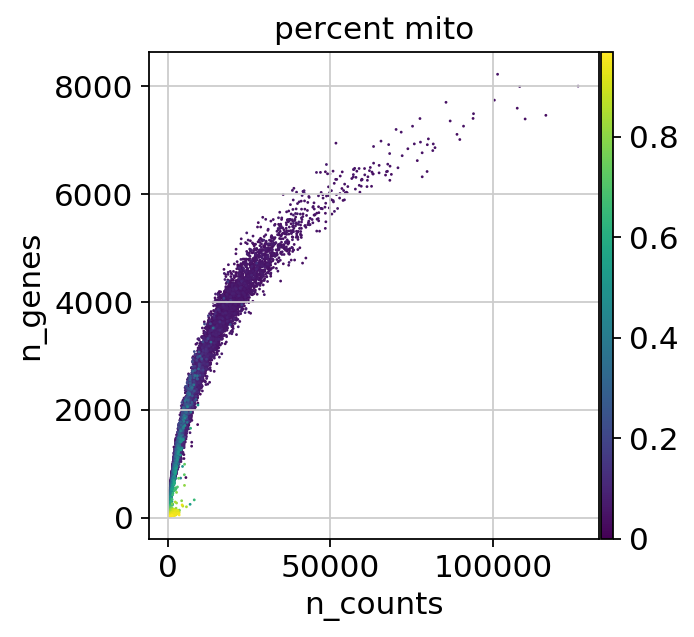

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


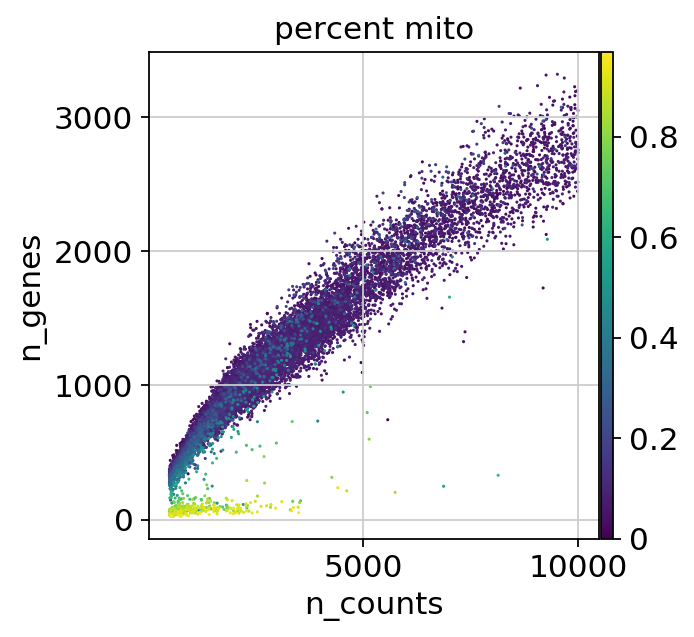

In [27]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='percent_mito')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='percent_mito')


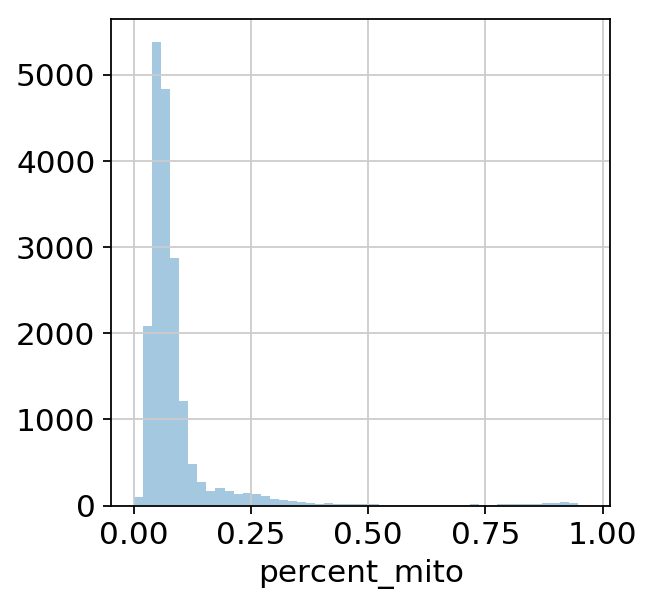

In [28]:
p3 = sns.distplot(adata.obs['percent_mito'], kde=False)
plt.show()

In [29]:
np.percentile(list(adata.obs['percent_mito']),20)

0.04476896896958352

In [30]:
len(adata[adata.obs['percent_mito'] > 0.2])

1360

In [31]:
len(adata[adata.obs['percent_mito'] > 0.2])/len(adata.obs)

0.07149240393208221

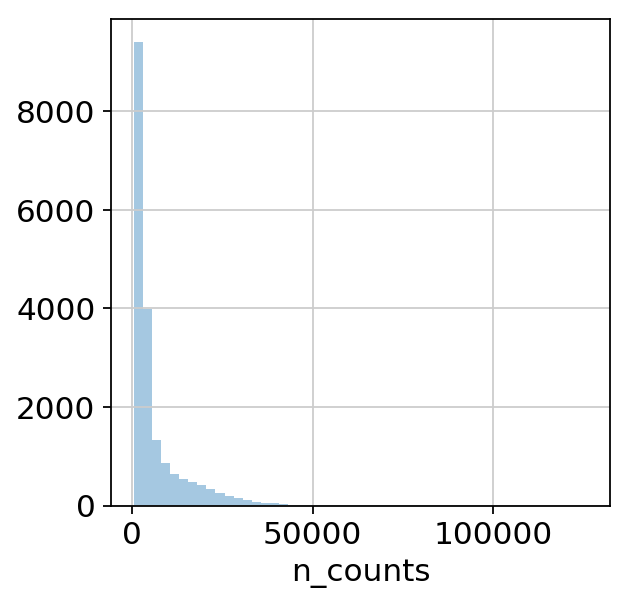

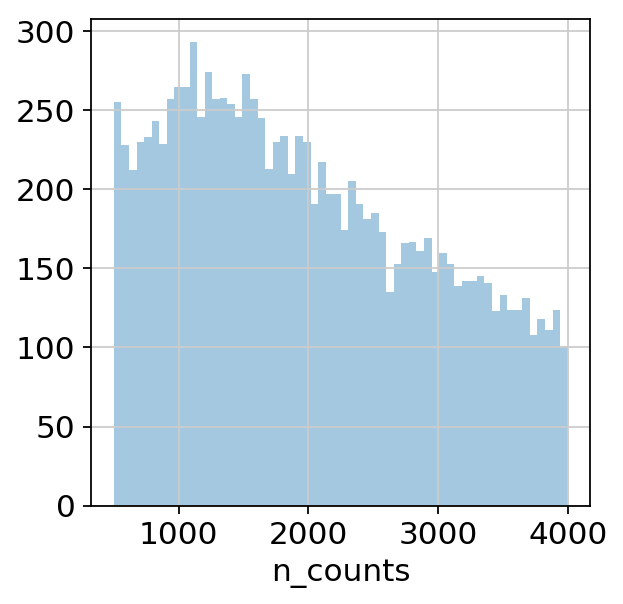

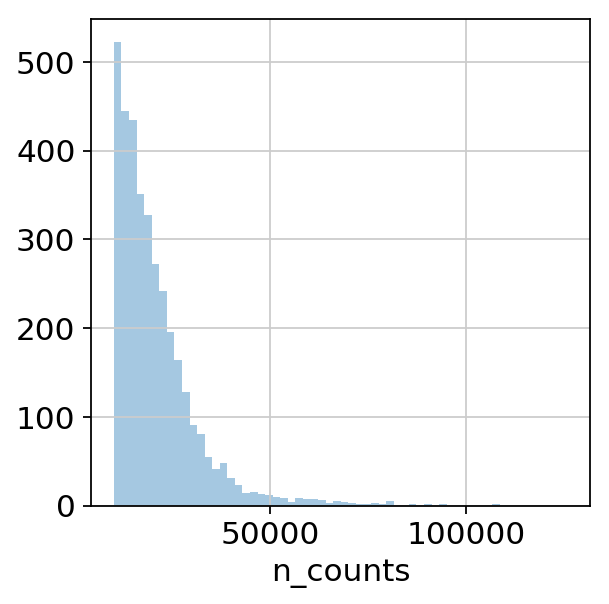

In [32]:
# Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()


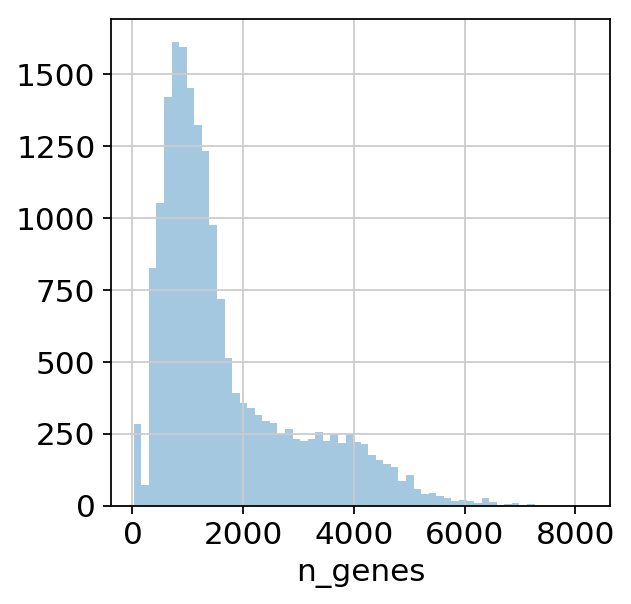

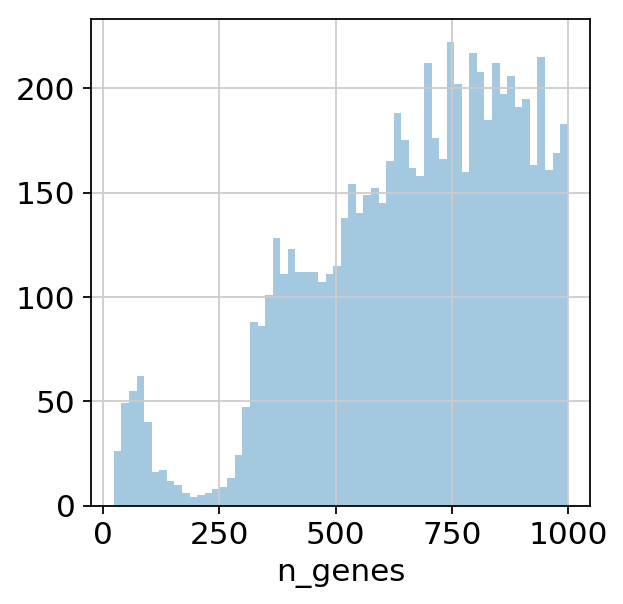

In [33]:
# Thresholding decision: genes
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

In [34]:
adata

AnnData object with n_obs × n_vars = 19023 × 33694 
    obs: 'activation', 'barcode_sample', 'batch', 'condition', 'n_counts', 'percent_mito', 'sample', 'technique', 'log_counts', 'n_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'gene_ids-5', 'feature_types-5', 'genome-5'

**Desicion**: gene cutoff: min_genes=200, min_cells=3, going back up to reread and filter there

In [35]:
np.unique(adata.obs['sample'])

array(['Immunodeficiency8103070', 'Immunodeficiency8103072',
       'Immunodeficiency8103073', 'Immunodeficiency8103074',
       'Immunodeficiency8103076', 'Immunodeficiency8103077'], dtype=object)

In [36]:
# quick check if the values are raw
check = adata[adata.obs['sample'] == 'Immunodeficiency8103070'].X.todense()
np.unique(check)

matrix([[   0.,    0.,    0., ..., 2261., 2508., 2668.]], dtype=float32)

____________________________________________________________________________________________________________

Carrying on to:
- Concatenate

In [38]:
%%time

adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
adata.X = adata.X.tocsr()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


CPU times: user 23.6 s, sys: 2.71 s, total: 26.3 s
Wall time: 26.3 s


Carrying on to 
- Filter MT-high cells (>20%)
- Save raw attribute
- Make cell names (obs) and gene names (var) unique

In [39]:
# mt % filtering
adata = adata[adata.obs['percent_mito'] < 0.2]

# saving the raw attribute
adata.raw = adata

adata.var_names_make_unique()
adata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [40]:
# adding 'is_doublet' annotation by throsholding the bh_pvalue, this is not the end of doublet calling
# this parameter can be tweaked according to how harsh the detection needs to be
# the less it is, the less doublets it will call
adata.obs['is_doublet'] = adata.obs['bh_pval'] < 0.1

In [41]:
adata

AnnData object with n_obs × n_vars = 17662 × 17976 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

In [43]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

In [44]:
adata.write(save_path+'adata_raw_filtered.h5ad')

... storing 'activation' as categorical
... storing 'condition' as categorical
... storing 'sample' as categorical
... storing 'technique' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'genome-1' as categorical
... storing 'gene_ids-2' as categorical
... storing 'feature_types-2' as categorical
... storing 'genome-2' as categorical
... storing 'gene_ids-3' as categorical
... storing 'feature_types-3' as categorical
... storing 'genome-3' as categorical
... storing 'gene_ids-4' as categorical
... storing 'feature_types-4' as categorical
... storing 'genome-4' as categorical
... storing 'gene_ids-5' as categorical
... storing 'feature_types-5' as categorical
... storing 'genome-5' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' 

In [45]:
# quick check if the values are raw
check = adata[adata.obs['sample'] == 'Immunodeficiency8103070'].X.todense()
np.unique(check)

matrix([[   0.,    0.,    0., ..., 2261., 2508., 2668.]], dtype=float32)

In [5]:
# reading
adata = sc.read(save_path+'adata_raw_filtered.h5ad')

In [6]:
adata.obs

,batch,bh_pval,cell_id,dataset,n_counts,n_genes,percent_mito,sample,scrublet_cluster_score,scrublet_score,stimulation,technique,is_doublet
index,,,,,,,,,,,,,
AAACCTGAGAATGTGT-1,0,0.831952,AAACCTGAGAATGTGT-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,7290.0,2702,0.018107,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.121951,0.228916,unstim,10X,False
AAACCTGAGACTAAGT-1,0,0.851680,AAACCTGAGACTAAGT-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,12742.0,3009,0.039083,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.103396,0.119403,unstim,10X,False
AAACCTGAGATCCCGC-1,0,0.796966,AAACCTGAGATCCCGC-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,801.0,509,0.031211,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.130053,0.071602,unstim,10X,False
AAACCTGAGCCGCCTA-1,0,0.851680,AAACCTGAGCCGCCTA-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,1274.0,630,0.039246,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.101341,0.062818,unstim,10X,False
AAACCTGAGCGCCTCA-1,0,0.966599,AAACCTGAGCGCCTCA-1_35008_CV005_RV9039258_and_3...,GEX+CITE-seq,1137.0,629,0.028144,35008_CV005_RV9039258_and_35008_CV005_RV9039282,0.090028,0.107668,unstim,10X,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGATCCCT-1,7,0.926996,TTTGTCATCGATCCCT-1_35008_CV005_RV9039265_and_3...,GEX+CITE-seq,974.0,597,0.024641,35008_CV005_RV9039265_and_35008_CV005_RV9039289,0.084559,0.078824,BCR,10X,False
TTTGTCATCGCTGATA-1,7,0.964333,TTTGTCATCGCTGATA-1_35008_CV005_RV9039265_and_3...,GEX+CITE-seq,1867.0,818,0.022496,35008_CV005_RV9039265_and_35008_CV005_RV9039289,0.074814,0.050420,BCR,10X,False
TTTGTCATCGTCTGCT-1,7,0.926996,TTTGTCATCGTCTGCT-1_35008_CV005_RV9039265_and_3...,GEX+CITE-seq,1418.0,792,0.031735,35008_CV005_RV9039265_and_35008_CV005_RV9039289,0.099391,0.119939,BCR,10X,False


# Producing a QC table

In [43]:
tables = {}

for sample in samples:
    print(sample)
    path = '/lustre/scratch117/cellgen/team292/aa22/data/202009_CVID_revision/cellranger302_count_'+sample+'_GRCh38-1_2_0/'
    tables[sample] = pd.read_csv(path + 'metrics_summary.csv')

35008_CV005_RV9039258_and_35008_CV005_RV9039282
35008_CV005_RV9039259_and_35008_CV005_RV9039283
35008_CV005_RV9039260_and_35008_CV005_RV9039284
35008_CV005_RV9039261_and_35008_CV005_RV9039285
35008_CV005_RV9039262_and_35008_CV005_RV9039286
35008_CV005_RV9039263_and_35008_CV005_RV9039287
35008_CV005_RV9039264_and_35008_CV005_RV9039288
35008_CV005_RV9039265_and_35008_CV005_RV9039289
35171_CV005_RV9039361
35171_CV005_RV9039362
35171_CV005_RV9039363
35171_CV005_RV9039364


In [44]:
table_merged = pd.DataFrame(columns = list(tables.values())[0].columns,
                           index = samples)

In [45]:
for sample in samples:
    print(sample)
    table_merged.loc[sample,:] = list(tables[sample].loc[0,:])

35008_CV005_RV9039258_and_35008_CV005_RV9039282
35008_CV005_RV9039259_and_35008_CV005_RV9039283
35008_CV005_RV9039260_and_35008_CV005_RV9039284
35008_CV005_RV9039261_and_35008_CV005_RV9039285
35008_CV005_RV9039262_and_35008_CV005_RV9039286
35008_CV005_RV9039263_and_35008_CV005_RV9039287
35008_CV005_RV9039264_and_35008_CV005_RV9039288
35008_CV005_RV9039265_and_35008_CV005_RV9039289
35171_CV005_RV9039361
35171_CV005_RV9039362
35171_CV005_RV9039363
35171_CV005_RV9039364


In [46]:
table_merged.to_csv('./QC_metrics_cellranger_all_samples.csv')

In [47]:
# number of cell called by cellranger
num_of_cells = [int(elem.split(',')[0]+elem.split(',')[1]) for elem in list(table_merged['Estimated Number of Cells'])]

In [48]:
num_of_cells

[17720,
 19435,
 12415,
 19832,
 22268,
 20522,
 19552,
 21186,
 21465,
 23553,
 29947,
 27418]

In [49]:
num_of_cells_total = np.sum(num_of_cells)

In [50]:
num_of_cells_total

255313